In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import re
import numpy as np
import pickle

# Daten laden

In [2]:
dfru = pd.read_pickle('data/dfru.pkl')

# Erfahrung der Reddituser, die in die Top Posts gekommen sind
### 1. Grafische Darstellung

In [3]:
dfru["created"] = pd.to_datetime(dfru["created_utc"], unit='s') 
dfru["time_since_creation"] = (datetime.now() - dfru["created"]) 
dfru["years_since_creation"] = dfru["time_since_creation"].dt.days/365

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


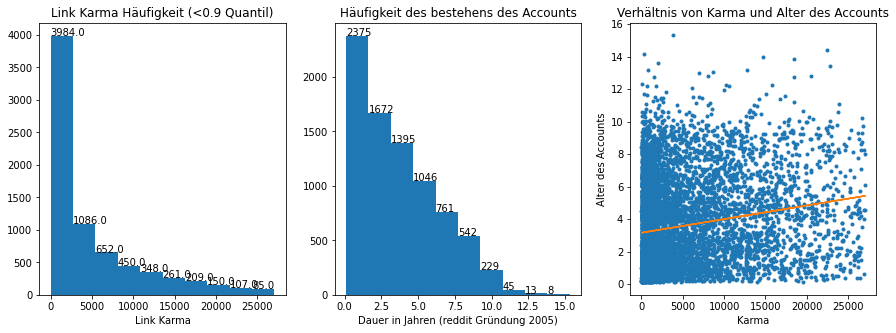

In [4]:
my_bins = 10

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

coef1 = np.polyfit(dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["link_karma"],
                   dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["years_since_creation"],
                   1)
poly1d_fn1 = np.poly1d(coef1) 

arr = ax1.hist(dfru[dfru["link_karma"]<dfru["link_karma"].quantile(0.9)]["link_karma"], bins=my_bins)
ax1.set_title("Link Karma Häufigkeit (<0.9 Quantil)")
ax1.set_xlabel("Link Karma")
for i in range(my_bins):
    ax1.text(arr[1][i],arr[0][i],str(arr[0][i]))


arr = ax2.hist(dfru[dfru["years_since_creation"]<20]["years_since_creation"], bins=my_bins)
ax2.set_title("Häufigkeit des bestehens des Accounts")
ax2.set_xlabel("Dauer in Jahren (reddit Gründung 2005)")
for i in range(my_bins):
    ax2.text(arr[1][i],arr[0][i],str(int(arr[0][i])))

ax3.plot(dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["link_karma"], 
         dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["years_since_creation"], 
         "o",
         dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["link_karma"],
         poly1d_fn1(dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)]["link_karma"]),
         markersize=3
        )
ax3.set_xlabel("Karma")
ax3.set_ylabel("Alter des Accounts")
ax3.set_title("Verhältnis von Karma und Alter des Accounts")

fig.show()

### 2. Statistischer Zusammenhang (Korrelation)

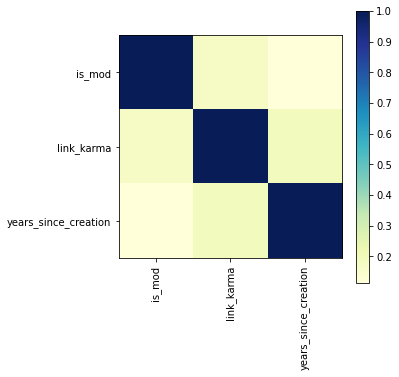

In [5]:
x = dfru[(dfru["link_karma"]<dfru["link_karma"].quantile(0.9))& (dfru["years_since_creation"]<20)][["is_mod","link_karma","years_since_creation"]].corr()

plt.figure(figsize=(5,5))
plt.imshow(x, cmap="YlGnBu")
plt.colorbar()


plt.xticks(range(len(x)),x.columns, rotation=90)

plt.yticks(range(len(x)),x.columns)
plt.show()

In [6]:
x

,is_mod,link_karma,years_since_creation
is_mod,1.000000,0.169631,0.114444
link_karma,0.169631,1.000000,0.187591
years_since_creation,0.114444,0.187591,1.000000


# Analyse der Moderatoren
### 1. Moderatoren- und Karmaverteilung

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


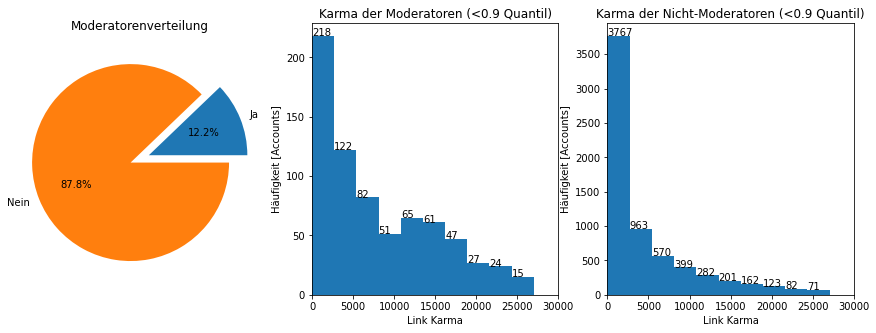

In [7]:
my_bins= 10 #Konfig

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.set_title("Moderatorenverteilung")    
ax1.pie([(dfru["is_mod"].sum()/dfru["is_mod"].count()), ((dfru["is_mod"].count()-dfru["is_mod"].sum())/dfru["is_mod"].count())], 
        labels=["Ja", "Nein"],
       autopct='%1.1f%%', explode=(0.1,0.1))


arr = ax2.hist(dfru[(dfru["is_mod"]==1)& (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"], bins=my_bins)
ax2.set_xlabel("Link Karma")
ax2.set_title("Karma der Moderatoren (<0.9 Quantil)")
ax2.set_ylabel("Häufigkeit [Accounts]")
ax2.set_xlim([0,30000])

for i in range(my_bins):
    ax2.text(arr[1][i],arr[0][i],str(int(arr[0][i])))

    

arr = ax3.hist(dfru[(dfru["is_mod"]==0)& (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"], bins=my_bins)
ax3.set_xlabel("Link Karma")
ax3.set_title("Karma der Nicht-Moderatoren (<0.9 Quantil)")
ax3.set_ylabel("Häufigkeit [Accounts]")
ax3.set_xlim([0,30000])
for i in range(my_bins):
    ax3.text(arr[1][i],arr[0][i],str(int(arr[0][i])))


fig.show()

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


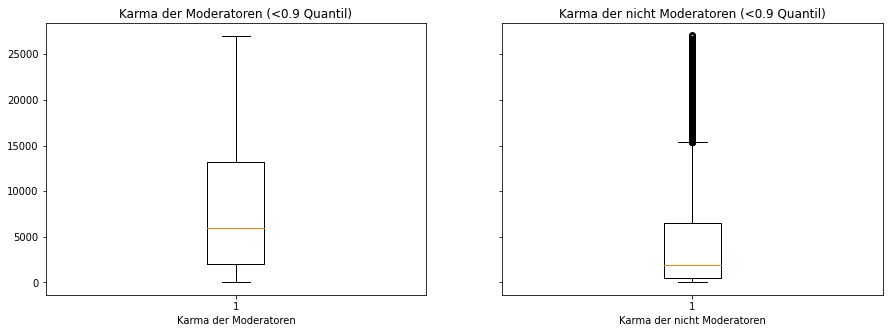

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=True)


ax1.boxplot(dfru[(dfru["is_mod"]==1) & (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"])
ax1.set_title("Karma der Moderatoren (<0.9 Quantil)")
ax1.set_xlabel("Karma der Moderatoren")

ax2.boxplot(dfru[(dfru["is_mod"]==0) & (dfru["link_karma"]< dfru["link_karma"].quantile(0.9))]["link_karma"])
ax2.set_title("Karma der nicht Moderatoren (<0.9 Quantil)")
ax2.set_xlabel("Karma der nicht Moderatoren")

fig.show()

# Mods & Erfolg im Datensatz

In [9]:
dfru = pd.read_pickle('data/dfru.pkl')
dfr = pd.read_pickle('data/dfr.pkl')
dfru.set_index("username", inplace=True)
new_df = dfr.join(dfru, on="author")

In [10]:
# Zeit normalisieren
new_df["day_created"] = pd.to_datetime(new_df["day_created"]).dt.date
new_df["time_created"] = pd.to_datetime(new_df["time_created"]).dt.time
new_df["curr_time"] = pd.to_datetime(new_df["curr_time"])

dtstuff = new_df.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
new_df["time"] = dtstuff
new_df["time"] = new_df["time"] - timedelta(hours=10)

In [11]:
# id erstellen
new_df["post_id"] = new_df.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig

In [12]:
# Max Ups hinzufügen
dfr = pd.merge(new_df, new_df.groupby("post_id")["ups"].agg("max").reset_index(), on="post_id")

# Max Comments hinzufügen
dfr = pd.merge(dfr, dfr.groupby("post_id")["num_comments"].agg("max").reset_index(), on="post_id")

dfr.rename({"ups_y":"max_ups", "num_comments_y":"max_comments", "ups_x":"ups", "num_comments_x":"num_comments"}, axis=1, inplace=True)

In [13]:
dfr_wod = dfr.drop_duplicates(subset=["post_id"]).copy()

In [14]:
dtstuff = dfr_wod.apply(
    lambda row: datetime.combine(datetime.today(), row['time'].time()),
    axis=1
)
dfr_wod["time_normalized"] = dtstuff

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


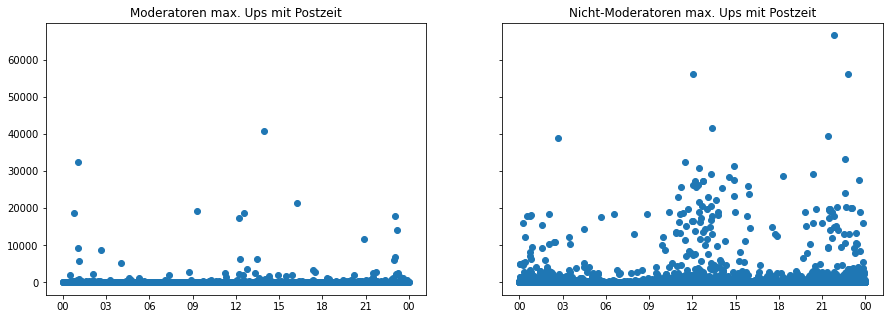

In [15]:
myFmt = pdt.DateFormatter("%H")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=True, sharex=False)

ax1.scatter(dfr_wod[dfr_wod["is_mod"]==1]["time_normalized"], dfr_wod[dfr_wod["is_mod"]==1]["max_ups"])
ax1.set_title("Moderatoren max. Ups mit Postzeit")
ax1.xaxis.set_major_formatter(myFmt)

ax2.scatter(dfr_wod[dfr_wod["is_mod"]==0]["time_normalized"], dfr_wod[dfr_wod["is_mod"]==0]["max_ups"])
ax2.set_title("Nicht-Moderatoren max. Ups mit Postzeit")
ax2.xaxis.set_major_formatter(myFmt)

fig.show()

In [16]:
mods = []
not_mods = []
hours = []
for hour in range(25):
    mods.append(dfr_wod[(dfr_wod["is_mod"]==1) & (dfr_wod["time_normalized"].dt.hour == hour)]["max_ups"].mean())
    not_mods.append(dfr_wod[(dfr_wod["is_mod"]==0) & (dfr_wod["time_normalized"].dt.hour == hour)]["max_ups"].mean())
    hours.append(hour)

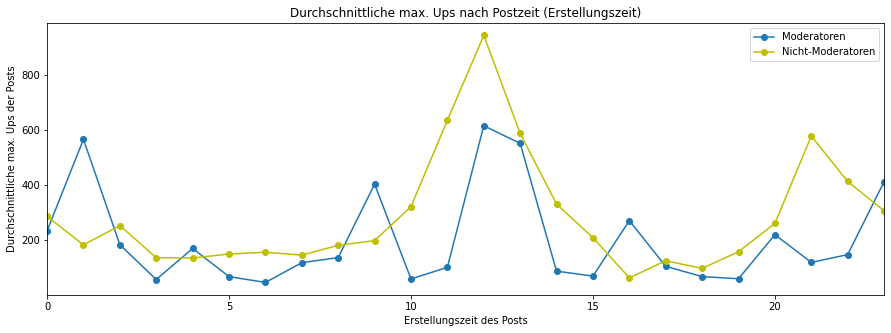

In [17]:
plt.figure(figsize=(15,5))

plt.plot(hours, mods, "-o", hours, not_mods, "-yo")
plt.title("Durchschnittliche max. Ups nach Postzeit (Erstellungszeit)")
plt.legend(["Moderatoren", "Nicht-Moderatoren"])
plt.xlim([0,23])

plt.xlabel("Erstellungszeit des Posts")
plt.ylabel("Durchschnittliche max. Ups der Posts")

plt.show()

In [18]:
mean_mod = dfr_wod[dfr_wod["is_mod"]==1]["max_ups"].mean()
mean_not_mod = dfr_wod[dfr_wod["is_mod"]==0]["max_ups"].mean()
print(f"Durchschnittliche maximale Upvotes\nfür Mods:{mean_mod}\nfür Nicht-Mods: {mean_not_mod}")

Durchschnittliche maximale Upvotes
für Mods:216.1384466956102
für Nicht-Mods: 295.1579136432215


In [19]:
mods = []
not_mods = []
hours = []
for hour in range(25):
    mods.append(dfr_wod[(dfr_wod["is_mod"]==1) & (dfr_wod["time_normalized"].dt.hour == hour)]["post_id"].count())
    not_mods.append(dfr_wod[(dfr_wod["is_mod"]==0) & (dfr_wod["time_normalized"].dt.hour == hour)]["post_id"].count())
    hours.append(hour)

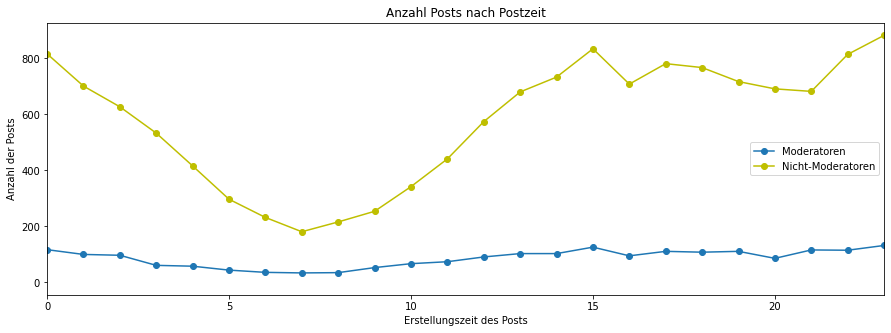

In [20]:
plt.figure(figsize=(15,5))

plt.plot(hours, mods, "-o", hours, not_mods, "-yo")
plt.title("Anzahl Posts nach Postzeit")
plt.legend(["Moderatoren", "Nicht-Moderatoren"])
plt.xlim([0,23])

plt.xlabel("Erstellungszeit des Posts")
plt.ylabel("Anzahl der Posts")
plt.show()